# Case 1 - Harvard Endowment

## FINM 36700 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

## HBS Case

### *The Harvard Management Company and Inflation-Indexed Bonds*

### Notation
(Hidden LaTeX commands)

$$\newcommand{\mux}{\tilde{\boldsymbol{\mu}}}$$
$$\newcommand{\wtan}{\boldsymbol{\text{w}}^{\text{tan}}}$$
$$\newcommand{\wtarg}{\boldsymbol{\text{w}}^{\text{port}}}$$
$$\newcommand{\mutarg}{\tilde{\boldsymbol{\mu}}^{\text{port}}}$$
$$\newcommand{\wEW}{\boldsymbol{\text{w}}^{\text{EW}}}$$
$$\newcommand{\wRP}{\boldsymbol{\text{w}}^{\text{RP}}}$$
$$\newcommand{\wREG}{\boldsymbol{\text{w}}^{\text{REG}}}$$

***

# 1. HMC's Approach

**Section 1 is not graded**, and you do not need to submit your answers. But you are encouraged to think about them, and we will discuss them.

### 1. 
There are thousands of individual risky assets in which HMC can invest.  Explain why MV optimization across 1,000 securities is infeasible.

### 2.
Rather than optimize across all securities directly, HMC runs a two-stage optimization.
1. They build asset class portfolios with each one optimized over the securities of the specific asset class.  
2. HMC combines the asset-class portfolios into one total optimized portfolio.

In order for the two-stage optimization to be a good approximation of the full MV-optimization on all assets, what must be true of the partition of securities into asset classes?

### 3.
Should TIPS form a new asset class or be grouped into one of the other 11 classes?

### 4. 
Why does HMC focus on real returns when analyzing its portfolio allocation? Is this just a matter of scaling, or does using real returns versus nominal returns potentially change the MV solution?

### 5.
The case discusses the fact that Harvard places bounds on the portfolio allocation rather than implementing whatever numbers come out of the MV optimization problem.

How might we adjust the stated optimization problem in the lecture notes to reflect the extra constraints Harvard is using in their bounded solutions given in Exhibits 5 and 6. Just consider how we might rewrite the optimization; don’t try to solve this extra-constrained optimization.

### 6. 
Exhibits 5 shows zero allocation to domestic equities and domestic bonds across the entire computed range of targeted returns, (5.75% to 7.25%). Conceptually, why is the constraint binding in all these cases? What would the unconstrained portfolio want to do with those allocations and why?

### 7.
Exhibit 6 changes the constraints, (tightening them in most cases.) How much deterioration do we see in the mean-variance tradeoff that Harvard achieved?

***

# **<span style="color:red">Solution 1</span>**

***

# 2 Mean-Variance Optimization

<i>This section is graded for a good-faith effort by your group. Submit your write-up- along with your supporting code. 
    
    Don't just submit code or messy numbers; submit a coherent write-up based on your work.</i>

### Data
You will need the file in the github repo, `data/multi_asset_etf_data.xlsx`.
- The time-series data gives monthly returns for the 11 asset classes and a short-term Treasury-bill fund return, ("SHV",) which we consider as the risk-free rate.
- The data is provided in total returns, (in which case you should ignore the SHV column,) as well as excess returns, (where SHV has been subtracted from the other columns.)
- These are nominal returns-they are not adjusted for inflation, and in our calculations we are not making any adjustment for inflation.
- The exhibit data that comes via Harvard with the case is unnecessary for our analysis.

### Model
We are going to analyze the problem in terms of **excess** returns.
- Thus, you will focus on the `Excess Returns` section of the lecture notes, especially the formulas on slide 50.
- Be sure to use the`excess returns` tab of the data.

### Format
In the questions below, **annualize the statistics** you report.
- Annualize the mean of monthly returns with a scaling of 12.
- Annualize the volatility of monthly returns with a scaling of $\sqrt{12}$
- The Sharpe Ratio is the mean return divided by the volatility of returns. Accordingly, we can annualize the Sharpe Ratio with a scaling of $\sqrt{12}$
- Note that we are not scaling the raw timeseries data, just the statistics computed from it (mean, vol, Sharpe). 

### Footnotes

#### Data File
* The case does not give time-series data, so this data has been compiled outside of the case, and it intends to represent the main asset classes under consideration via various ETFs. For details on the specific securities/indexes, check the “Info” tab of the data.

#### Risk-free rate
* In the lecture-note we considered a constant risk-free rate. It is okay that our risk-free rate changes over time, but the assumption is that investors know it’s value one-period ahead of time. Thus, at any given point in time, it is a risk-free rate for the next period. (This is often discussed as the "bank account" or "money market account" in other settings.

## 1. Summary Statistics
* Calculate and display the mean and volatility of each asset’s excess return. (Recall we use volatility to refer to standard deviation.)
* Which assets have the best and worst Sharpe ratios? Recall that the Sharpe Ratio is simply the ratio of the mean-to-volatility of excess returns:
$$\text{sharpe ratio of investment }i = \frac{\mux_i}{\sigma_i}$$

## 2. Descriptive Analysis
* Calculate the correlation matrix of the returns. Which pair has the highest correlation? And the lowest?
* How well have TIPS done in our sample? Have they outperformed domestic bonds? Foreign bonds?

## 3. The MV frontier.
* Compute and display the weights of the tangency portfolios: $\wtan$.
* Does the ranking of weights align with the ranking of Sharpe ratios?
* Compute the mean, volatility, and Sharpe ratio for the tangency portfolio corresponding to
$\wtan$.

## 4. TIPS
Assess how much the tangency portfolio (and performance) change if...
* TIPS are dropped completely from the investment set.
* The expected excess return to TIPS is adjusted to be 0.0012 higher than what the historic sample shows.

Based on the analysis, do TIPS seem to expand the investment opportunity set, implying that Harvard should consider them as a separate asset?

***

# **<span style="color:red">Solution 2</span>**

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

## Data

In [3]:
filepath_data = '../data/multi_asset_etf_data.xlsx'
info = pd.read_excel(filepath_data,sheet_name='descriptions')
info.set_index('ticker',inplace=True)

In [4]:
rets = pd.read_excel(filepath_data,sheet_name='total returns')
rets.set_index('Date',inplace=True)
rets.drop(columns=['SHV'])

retsx = pd.read_excel(filepath_data,sheet_name='excess returns')
retsx.set_index('Date',inplace=True)

# sort columns by order of descriptions in Info tab
symbol_list = info.index.drop('SHV')
rets = rets[symbol_list]
retsx = retsx[symbol_list]

In [5]:
info

,shortName,quoteType,currency,volume,totalAssets,longBusinessSummary
ticker,,,,,,
SPY,SPDR S&P 500,ETF,USD,42926953,412799303680,The Trust seeks to achieve its investment obje...
EFA,iShares MSCI EAFE ETF,ETF,USD,9234292,48446230528,The fund generally will invest at least 80% of...
EEM,iShares MSCI Emerging Index Fun,ETF,USD,21697929,21355970560,The fund generally will invest at least 80% of...
PSP,Invesco Global Listed Private E,ETF,USD,2557,214931952,The fund generally will invest at least 90% of...
QAI,IQ Hedge MultiIQ Hedge Multi-St,ETF,USD,16734,624121728,"The fund is a ""fund of funds"" which means it i..."
HYG,iShares iBoxx $ High Yield Corp,ETF,USD,18515962,14783441920,The underlying index is a rules-based index co...
DBC,Invesco DB Commodity Index Trac,ETF,USD,506418,2091483648,The fund pursues its investment objective by i...
IYR,iShares U.S. Real Estate ETF,ETF,USD,4115950,2840025600,The fund seeks to track the investment results...
IEF,iShares 7-10 Year Treasury Bond,ETF,USD,4696390,28524961792,The underlying index measures the performance ...


In [6]:
retsx

,SPY,EFA,EEM,PSP,QAI,HYG,DBC,IYR,IEF,BWX,TIP
Date,,,,,,,,,,,
2009-04-30,0.0988,0.1146,0.1550,0.2296,0.0223,0.1379,-0.0016,0.2956,-0.0280,0.0084,-0.0185
2009-05-31,0.0589,0.1324,0.1599,0.0544,0.0283,0.0290,0.1631,0.0232,-0.0203,0.0541,0.0204
2009-06-30,-0.0013,-0.0146,-0.0231,0.0414,-0.0040,0.0329,-0.0269,-0.0255,-0.0062,0.0045,0.0014
2009-07-31,0.0746,0.1004,0.1102,0.1433,0.0154,0.0692,0.0186,0.1058,0.0083,0.0313,0.0009
2009-08-31,0.0365,0.0446,-0.0136,0.0330,-0.0046,-0.0174,-0.0408,0.1315,0.0072,0.0072,0.0080
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,0.0129,0.0263,-0.0115,0.0315,0.0020,-0.0011,-0.0107,0.0061,0.0051,-0.0056,-0.0026
2023-05-31,0.0014,-0.0433,-0.0273,-0.0224,-0.0097,-0.0156,-0.0673,-0.0435,-0.0176,-0.0292,-0.0152
2023-06-30,0.0601,0.0400,0.0392,0.0420,0.0179,0.0131,0.0247,0.0526,-0.0173,0.0034,-0.0081


## Functions that will be useful
### Basic performance metrics

In [7]:
def performanceMetrics(returns,annualization=1):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * annualization
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)

    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()

    return metrics

### Tangency portfolio

In [8]:
def tangency_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    return pd.DataFrame(weights, index=returns.columns)

## **<span style="color:red">Solution 2.1</span>**

In [9]:
mets = performanceMetrics(retsx,annualization=12)
mets.sort_values('Sharpe',ascending=False)

,Mean,Vol,Sharpe,Min,Max
SPY,0.1437,0.1477,0.9732,-0.1290,0.1268
HYG,0.0642,0.0892,0.7197,-0.1044,0.1379
IYR,0.1295,0.1871,0.6920,-0.2005,0.2956
EFA,0.0816,0.1660,0.4916,-0.1452,0.1429
TIP,0.0223,0.0515,0.4332,-0.0676,0.0422
QAI,0.0190,0.0508,0.3734,-0.0605,0.0364
PSP,0.0799,0.2274,0.3516,-0.2951,0.2296
EEM,0.0649,0.1965,0.3302,-0.1791,0.1628
IEF,0.0143,0.0624,0.2287,-0.0476,0.0461
DBC,0.0254,0.1790,0.1422,-0.1776,0.1631


The high/low Sharpe stand out clearly:
* Highest Sharpe: `SPY`, S&P 500 equities
* Lowest Sharpe: `BWX`, international Treasury bonds (investment grade)

## **<span style="color:red">Solution 2.2</span>**

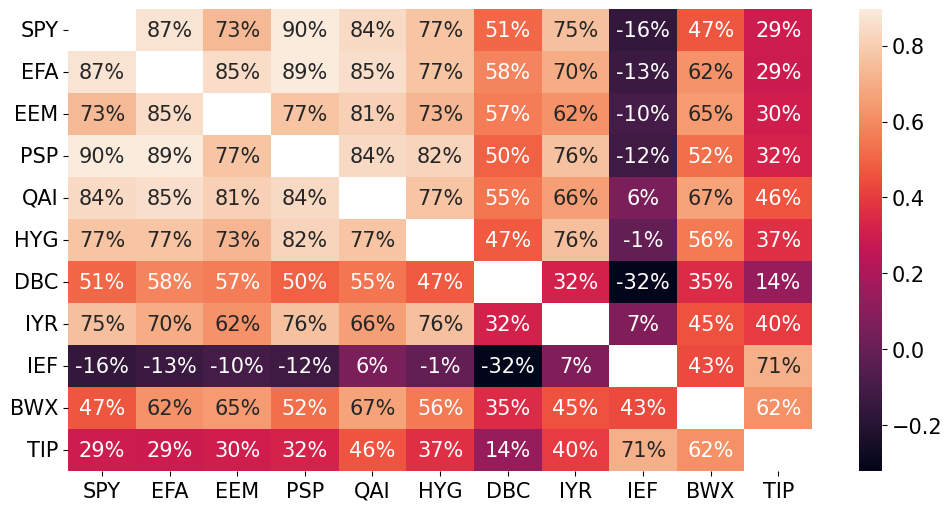

In [10]:
corrmat = retsx.corr()
corrmat[corrmat==1] = None
sns.heatmap(corrmat,annot=True,fmt='.0%');

In [11]:
corr_rank = corrmat.unstack().sort_values().dropna()
pair_max = corr_rank.index[-1]
pair_min = corr_rank.index[0]

print(f'MIN Correlation pair is {pair_min}')
print(f'MAX Correlation pair is {pair_max}')

MIN Correlation pair is ('IEF', 'DBC')
MAX Correlation pair is ('SPY', 'PSP')


### TIPS

TIPS have **substantially** outperformed both domestic bonds (`IEF`) and international bonds (`BWX`) in terms of mean, vol, and Sharpe.

* TIPS have an above-average Sharpe ratio, (relative to these 11 assets.)
* TIPS have a low mean, but a very low volatility. 

Regarding correlation,
* TIPS have low correlations to most the other assets.
* TIPS have substantial correlation to IEF and BWX. But these correlations are ~60% and 70%--well below the correlation between SPY and most the equity-based investments. 

## **<span style="color:red">Solution 2.3</span>**

In [12]:
wts = pd.DataFrame(index=retsx.columns)
wts['tangency'] = tangency_weights(retsx)

port = pd.DataFrame(retsx @ wts['tangency'],columns=['tangency'])
performanceMetrics(port,annualization=12)

,Mean,Vol,Sharpe,Min,Max
tangency,0.3702,0.1915,1.9328,-0.1087,0.2041


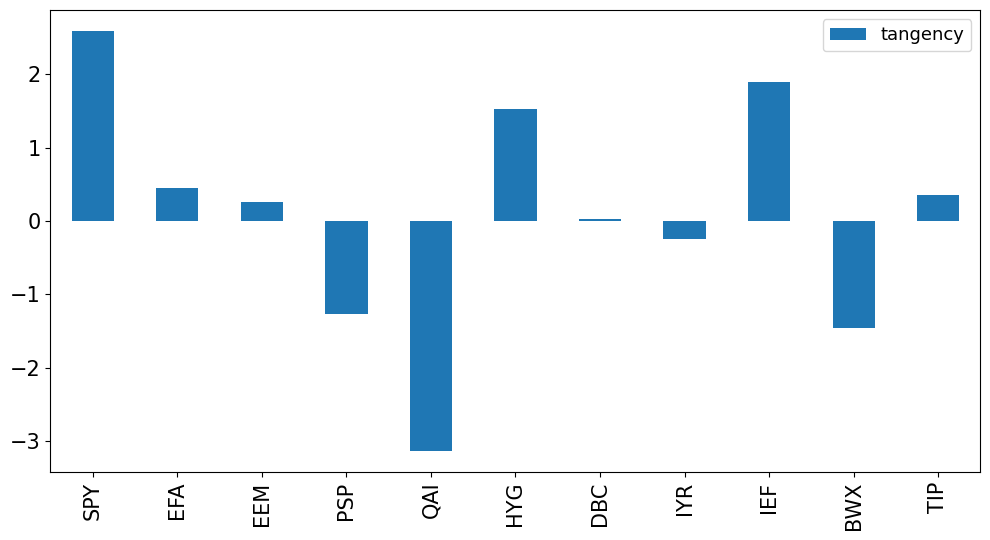

In [13]:
wts.plot.bar();

Note that the performance stats of the tangency portfolio barely change after dropping TIPS. 

Furthermore, the weights in the other assets do not change substantially from dropping TIPS.

This suggests TIPS are not substantially adding to the investment opportunity set relative to the mean-variance outcomes of the other 10 assets.

### Sharpe aligned w/ Weights?

Consider whether the Sharpe rankings align with the weight rankings...

In [14]:
pd.concat([wts['tangency'],mets['Sharpe']],axis=1).sort_values('tangency',ascending=False)

,tangency,Sharpe
SPY,2.5900,0.9732
IEF,1.8940,0.2287
HYG,1.5289,0.7197
EFA,0.4529,0.4916
TIP,0.3569,0.4332
EEM,0.2610,0.3302
DBC,0.0284,0.1422
IYR,-0.2428,0.6920
PSP,-1.2711,0.3516
BWX,-1.4650,-0.0221


We see that the tangency weights ranking is quite different from the Sharpe rankings. (Correlation between the two series is only about 50%.)

## **<span style="color:red">Solution 2.4</span>**

#### Weights if drop TIPS from investment set

In [15]:
wts['tangency ex tips'] = tangency_weights(retsx.drop(columns=['TIP']))
wts.loc['TIP','tangency ex tips'] = 0

#### Weights if adjust TIPS mean upward

In [16]:
TIPS_ADJ = .0012
retsx_adj = retsx.copy()
retsx_adj['TIP'] += TIPS_ADJ

wts['tan tips adj'] = tangency_weights(retsx_adj)

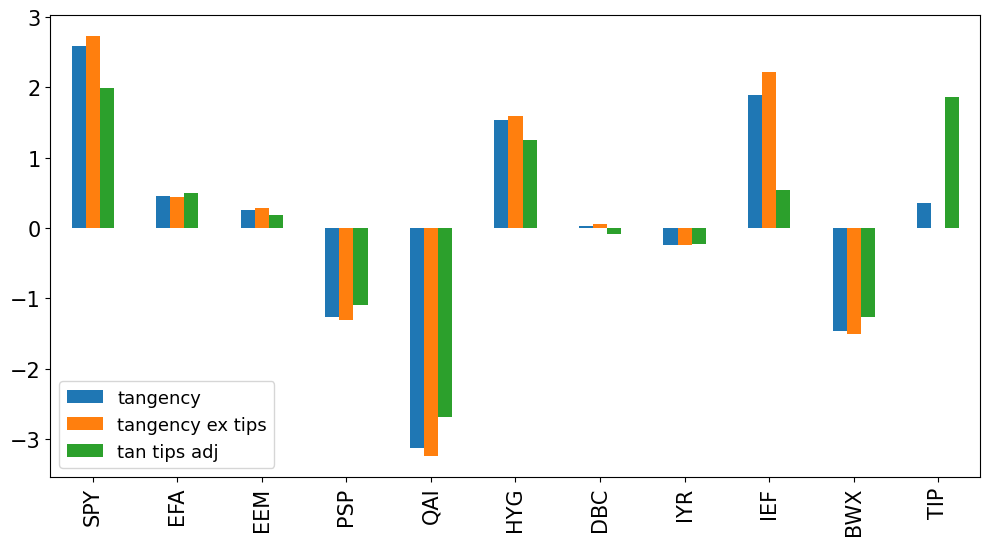

In [17]:
wts.plot.bar();

In [18]:
port['tan extips'] = pd.DataFrame(retsx @ wts['tangency ex tips'],columns=['tangency ex tips'])
port['tips adj'] = retsx_adj @ wts['tan tips adj']
performanceMetrics(port,annualization=12)

,Mean,Vol,Sharpe,Min,Max
tangency,0.3702,0.1915,1.9328,-0.1087,0.2041
tan extips,0.3863,0.2001,1.9304,-0.1151,0.2117
tips adj,0.3289,0.1619,2.0310,-0.0805,0.1772


#### Uncertainty in mean returns
Note that our adjustment to the mean return of TIPS is not so large relative to the standard error of TIPS.

In [19]:
tips_se = retsx['TIP'].std()/np.sqrt(retsx.shape[0])
print(f'Standard error of mean of TIPS is equal to {tips_se:0.4f}')

Standard error of mean of TIPS is equal to 0.0011


### Conclusions on TIPS

* Dropping TIPS from the investment set barely impacts the weights or the resulting performance.
* Adjusting the mean of TIPS upward even just 1 standard error substantially impacts the allocations and moderately boosts the resulting performance.

Based on just a mean-variance analysis, it seems one could reasonably go either way with TIPS as an alternate asset class. In the argument to keep it separate, there is more diversification between TIPS and bonds than between SPY and many other equity buckets Harvard has. On the other hand, TIPS mostly impact the allocation to domestic bonds and might be seen as another asset in that bucket.

***

# 3. Allocations

<i>This section is graded for a good-faith effort by your group. Submit your write-up- along with your supporting code.

* Continue with the same data file as the previous section.

* Suppose the investor has a targeted mean excess return (per month) of $\mutarg$ = 0.01.

Build the following portfolios:

#### Equally-weighted (EW)
Rescale the entire weighting vector to have target mean $\mutarg$. Thus, the $i$ element of the weight vector is,
$$\wEW_i = \frac{1}{n}$$

#### “Risk-parity” (RP)
Risk-parity is a term used in a variety of ways, but here we have in mind setting the weight of the portfolio to be proportional to the inverse of its full-sample variance estimate. Thus, the $i$ element of the weight vector is,
$$\wRP_i = \frac{1}{\sigma_i^2}$$

#### Regularized (REG)
Much like the Mean-Variance portfolio, set the weights proportional to 
$$\wREG \sim \widehat{\Sigma}^{-1}\mux$$
but this time, use a regularized covariance matrix,
$$\widehat{\Sigma} = \frac{\Sigma + \Sigma_D}{2}$$
where $\Sigma_D$ denotes a *diagonal* matrix of the security variances, with zeros in the off-diagonals.

Thus, $\widehat{\Sigma}$ is obtained from the usual covariance matrix, $\Sigma$, but shrinking all the covariances to half their estimated values. 


### Comparing

In order to compare all these allocation methods, (those above, along with the tangency portfolio obtained in the previous section,) rescale each weight vector, such that it has targeted mean return of $\mutarg$.

* Calculate the performance of each of these portfolios over the sample.
* Report their mean, volatility, and Sharpe ratio. 
* How do these compare across the four allocation methods?

***

# **<span style="color:red">Solution 3</span>**

In [20]:
TARG_MEAN = .015

In [21]:
wts['equal weights'] = 1/len(retsx.columns)
wts['risk parity'] = 1/retsx.var()
wts['regularized'] = tangency_weights(retsx,scale_cov=.5)

# rescale these to hit the target mean
wts *= TARG_MEAN / (retsx.mean()@wts)

In [22]:
performanceMetrics(retsx @ wts,annualization=12)

,Mean,Vol,Sharpe,Min,Max
tangency,0.1800,0.0931,1.9328,-0.0528,0.0992
tangency ex tips,0.1800,0.0932,1.9304,-0.0536,0.0986
tan tips adj,0.1800,0.0965,1.8650,-0.0493,0.1043
equal weights,0.1800,0.3199,0.5627,-0.3652,0.2840
risk parity,0.1800,0.3265,0.5513,-0.3498,0.2354
regularized,0.1800,0.1411,1.2753,-0.1117,0.1566


***

# 4. Out-of-Sample Performance

<i>This section is not graded, and you do not need to submit it. Still, we may discuss it in class, in which case, you would be expected to know it.

## 1. One-step Out-of-Sample (OOS) Performance
Let’s divide the sample to both compute a portfolio and then check its performance out of sample.
* Using only data through the end of 2021, compute the weights built in Section 3.
* Rescale the weights, (using just the in-sample data,) to set each allocation to have the same mean return of $\mutarg$.
* Using those weights, calculate the portfolio’s Sharpe ratio within that sample.
* Again using those weights, (derived using data through 2021,) calculate the portfolio’s OOS Sharpe ratio, which is based only on performance in 2022-2023.

## 2. Rolling OOS Performance

Iterate the Out-of-Sample performance every year, not just the final year. Namely,
* Start at the end of 2014, and calculate the weights through that time. Rescale them using the mean returns through that time.
* Apply the weights to the returns in the upcoming year, (2015.)
* Step forward a year in time, and recompute.
* Continue until again calculating the weights through 2022 and applying them to the returns in 2023.

Report the mean, volatility, and Sharpe from this dynamic approach for the following portfolios:
* mean-variance (tangency)
* equally-weighted
* risk-parity
* regularized

***

# **<span style="color:red">Solution 4</span>**

## **<span style="color:red">Solution 4.1</span>**

In [23]:
SPLIT0 = '2020'
SPLIT1 = '2021'

retsxIS = retsx.loc[:SPLIT0]
retsxOOS = retsx.loc[SPLIT1:]

retsxIS_adj = retsxIS.copy()
retsxIS_adj['TIP'] += TIPS_ADJ

wtsIS = pd.DataFrame(index=wts.index, columns=wts.columns, dtype=float)
wtsIS['tangency'] = tangency_weights(retsxIS)

wtsIS['tangency ex tips'].iloc[:-1] = tangency_weights(retsxIS.drop(columns=['TIP'])).values[:,0]
wtsIS.loc['TIP','tangency ex tips'] = 0

wtsIS['tan tips adj'] = tangency_weights(retsxIS_adj)
wtsIS['equal weights'] = 1/len(retsxIS.columns)
wtsIS['risk parity'] = 1/retsxIS.var()
wtsIS['regularized'] = tangency_weights(retsxIS,scale_cov=.5)

# rescale these to hit the target mean
wtsIS *= TARG_MEAN / (retsxIS.mean()@wtsIS)

performanceMetrics(retsxIS @ wtsIS,annualization=12)

,Mean,Vol,Sharpe,Min,Max
tangency,0.1800,0.0716,2.5134,-0.0306,0.0824
tangency ex tips,0.1800,0.0719,2.5042,-0.0297,0.0805
tan tips adj,0.1800,0.0734,2.4534,-0.0328,0.0927
equal weights,0.1800,0.2466,0.7299,-0.2906,0.2259
risk parity,0.1800,0.1868,0.9634,-0.1893,0.1272
regularized,0.1800,0.1092,1.6483,-0.0759,0.1135


In [24]:
performanceMetrics(retsxOOS @ wtsIS,annualization=12)

,Mean,Vol,Sharpe,Min,Max
tangency,0.0305,0.1509,0.2020,-0.0789,0.1106
tangency ex tips,0.0261,0.1497,0.1746,-0.0825,0.1091
tan tips adj,0.0418,0.1564,0.2674,-0.0695,0.1226
equal weights,-0.0190,0.2863,-0.0663,-0.2020,0.1551
risk parity,-0.1638,0.3040,-0.5390,-0.2382,0.1556
regularized,-0.0695,0.2037,-0.3410,-0.1344,0.1323


## **<span style="color:red">Solution 4.2</span>**

### Rebalancing annually

In [25]:
portOOS = pd.DataFrame(index=retsx.index,columns=wts.columns,dtype=float)
for yr in range(2013,2023):
    yr0 = f'{yr}'
    yr1 = f'{yr+1}'
    retsxIS = retsx.loc[:yr0]
    retsxOOS = retsx.loc[yr1]

    retsxIS_adj = retsxIS.copy()
    retsxIS_adj['TIP'] += TIPS_ADJ

    wtsIS = pd.DataFrame(index=wts.index, columns=wts.columns, dtype=float)
    wtsIS['tangency'] = tangency_weights(retsxIS)

    wtsIS['tangency ex tips'].iloc[:-1] = tangency_weights(retsxIS.drop(columns=['TIP'])).values[:,0]
    wtsIS.loc['TIP','tangency ex tips'] = 0

    wtsIS['tan tips adj'] = tangency_weights(retsxIS_adj)
    wtsIS['equal weights'] = 1/len(retsxIS.columns)
    wtsIS['risk parity'] = 1/retsxIS.var()
    wtsIS['regularized'] = tangency_weights(retsxIS,scale_cov=.5)

    # rescale these to hit the target mean
    wtsIS *= TARG_MEAN / (retsxIS.mean()@wtsIS)
    
    portOOS.loc[yr1] = retsxOOS @ wtsIS

### Rebalancing monthly

In [26]:
portOOS = pd.DataFrame(index=retsx.index,columns=wts.columns,dtype=float)
for i, month in enumerate(portOOS.index):
    if i > 50:
        retsxIS = retsx.iloc[:i]
        retsxOOS = retsx.iloc[i]

        retsxIS_adj = retsxIS.copy()
        retsxIS_adj['TIP'] += TIPS_ADJ

        wtsIS = pd.DataFrame(index=wts.index, columns=wts.columns, dtype=float)
        wtsIS['tangency'] = tangency_weights(retsxIS)

        wtsIS['tangency ex tips'].iloc[:-1] = tangency_weights(retsxIS.drop(columns=['TIP'])).values[:,0]
        wtsIS.loc['TIP','tangency ex tips'] = 0

        wtsIS['tan tips adj'] = tangency_weights(retsxIS_adj)
        wtsIS['equal weights'] = 1/len(retsxIS.columns)
        wtsIS['risk parity'] = 1/retsxIS.var()
        wtsIS['regularized'] = tangency_weights(retsxIS,scale_cov=.5)

        # rescale these to hit the target mean
        wtsIS *= TARG_MEAN / (retsxIS.mean()@wtsIS)

        portOOS.iloc[i,:] = retsxOOS @ wtsIS

In [27]:
performanceMetrics(portOOS,annualization=12)

,Mean,Vol,Sharpe,Min,Max
tangency,0.1275,0.0977,1.3052,-0.0517,0.1096
tangency ex tips,0.1284,0.0964,1.3318,-0.0562,0.1085
tan tips adj,0.1297,0.1016,1.2766,-0.0486,0.1127
equal weights,0.0804,0.2529,0.3180,-0.3197,0.1998
risk parity,0.0505,0.2564,0.1968,-0.3213,0.2444
regularized,0.0753,0.1304,0.5778,-0.1268,0.1384


***

# 5. Without a Riskless Asset

<i>This section is not graded, and you do not need to submit it. Still, we may discuss it in class, in which case, you would be expected to know it.

Re-do Section 2 above, but in the model without a risk-free rate.

That is, build the MV allocation using the two-part formula in the `Mean-Variance` section of the notes.
* This essentially substitutes the risk-free rate with the minimum-variance portfolio.
* Now, the allocation depends nonlinearly on the target mean return, $\mutarg$. (With a risk-free rate, we simply scale the weights up and down to achieve the mean return.)

You will find that, conceptually, the answers are very similar. 

***

# **<span style="color:red">Solution 5</span>**

The solutions are very similar! The constructed minimum-variance portfolio replaces the riskless asset, and the resulting weights and portfolio performances are similar.

### Illustration of the MV Frontier

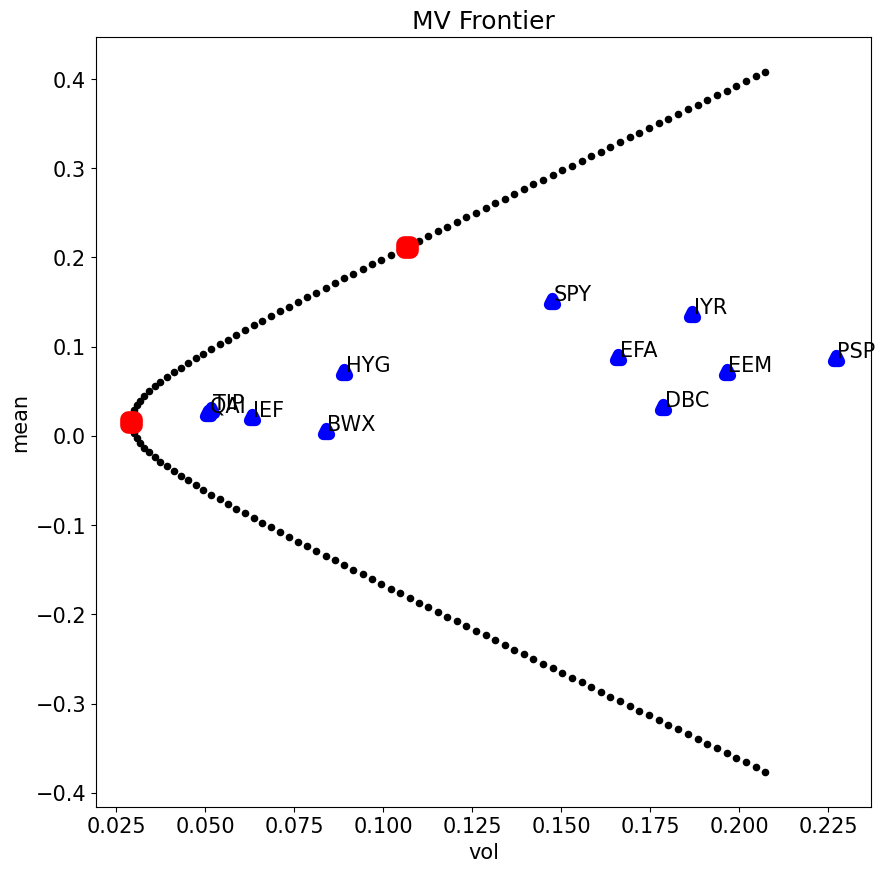

In [28]:
import warnings
warnings.filterwarnings('ignore')

omega_tan = tangency_weights(rets)
rets_adj = rets - rets.mean() + 1
omega_gmv = tangency_weights(rets_adj)
omega = pd.concat([omega_tan,omega_gmv],axis=1)
omega.columns = ['tangency','gmv']

delta_grid = np.linspace(-2,2,150)
mv_frame = pd.DataFrame(columns=['mean','vol'],index=delta_grid)
for i, delta in enumerate(delta_grid):
    omega_mv = delta * omega_tan + (1-delta) * omega_gmv
    rets_p = rets @ omega_mv
    mv_frame['mean'].iloc[i] = rets_p.mean().values[0] * 12
    mv_frame['vol'].iloc[i] = rets_p.std().values[0] * np.sqrt(12)
    
rets_special = pd.DataFrame(index=rets.index)
rets_special['tan'] = rets @ omega_tan.values
rets_special['gmv'] = rets @ omega_gmv.values

mv_assets = pd.concat([rets.mean() * 12,rets.std() * np.sqrt(12)],axis=1)
mv_special = pd.concat([rets_special.mean() * 12, rets_special.std() * np.sqrt(12)],axis=1)
mv_assets.columns = ['mean','vol']
mv_special.columns = ['mean','vol']

ax = mv_frame.plot.scatter(x='vol',y='mean', c='k', figsize=(10,10), title='MV Frontier')
mv_assets.plot.scatter(x='vol',y='mean',ax=ax, c='b', marker='^', linewidth=8)
mv_special.plot.scatter(x='vol',y='mean',ax=ax, c='r', marker='s', linewidth=12)

for i in range(mv_assets.shape[0]):
    plt.text(x=mv_assets['vol'][i]+.0005, y=mv_assets['mean'][i]+.0005, s=mv_assets.index[i])